# Part 1: Performance Benchmarking

**Class 3 — Non-Functional Testing & AI Security**

---

## Objective

1. Measure inference **latency** (p50, p95, p99 percentiles) across different batch sizes
2. Measure **throughput** (images/second) and **memory usage** (MB)
3. Apply **model quantization** (`torch.quantization`) to compress the model
4. Compare accuracy drop vs speed gain from quantization
5. Understand the **performance vs accuracy tradeoff**

---

## Key Concepts

| Concept | Definition |
|---------|------------|
| **Latency** | Time to process a single request (or batch). p50 = median, p95 = 95th percentile, p99 = worst-case SLA |
| **Throughput** | Images processed per second = `batch_size / latency_per_batch` |
| **Memory Usage** | RAM consumed by model + intermediate tensors during inference |
| **Dynamic Quantization** | Convert FP32 weights → INT8 at inference time, no retraining needed |
| **Latency Percentiles** | p95 and p99 matter more than mean for production SLA guarantees |

---

## Why This Matters in Production

- **SLA (Service Level Agreement)**: Customers expect < 200ms response. p99 must be within SLA.
- **Cost efficiency**: Higher throughput = fewer servers needed = lower cloud bill.
- **Edge deployment**: Quantized models fit on embedded hardware (NVIDIA Jetson, Raspberry Pi).
- **ADAS context**: A car driving at 60 km/h moves 16 meters per second — latency directly impacts safety.

In [1]:
# ── Section 1: Setup & Imports ──────────────────────────────────────────────
import os
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset path
DATASET_PATH = r'C:\Users\Lucifer\python_workspace\BITS\AI_Quality_Engineering\dataset'
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Class names (consistent with class2)
CLASS_NAMES = ['animal', 'name_board', 'vehicle', 'pedestrian',
               'pothole', 'road_sign', 'speed_breaker']
NUM_CLASSES = len(CLASS_NAMES)

print(f'Device: {DEVICE}')
print(f'PyTorch version: {torch.__version__}')
print(f'Classes: {CLASS_NAMES}')
print('All imports successful!')

Device: cpu
PyTorch version: 2.1.0+cpu
Classes: ['animal', 'name_board', 'vehicle', 'pedestrian', 'pothole', 'road_sign', 'speed_breaker']
All imports successful!


In [2]:
# ── Section 2: Model Definition ─────────────────────────────────────────────
class ADASModel(nn.Module):
    """
    ResNet-18 baseline for ADAS road hazard classification.
    Identical to class2 BaselineModel.
    """
    def __init__(self, num_classes: int = 7):
        super().__init__()
        self.resnet = resnet18(weights=None)  # Random weights for demo
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet(x)


# Image transform (same pipeline as class1/class2)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load model and set to evaluation mode
model = ADASModel(NUM_CLASSES).to(DEVICE)
model.eval()

total_params = sum(p.numel() for p in model.parameters())
print(f'Model: ADASModel (ResNet-18)')
print(f'Total parameters: {total_params:,}')
print(f'Device: {DEVICE}')

# NOTE: Using random weights (pretrained=False) for the demo.
# In production, load your trained checkpoint:
#   model.load_state_dict(torch.load('models/v1/model.pth', map_location=DEVICE))

Model: ADASModel (ResNet-18)
Total parameters: 11,180,103
Device: cpu


## Section 3: Benchmarking Functions

We define four measurement utilities:

1. `measure_latency()` — p50/p95/p99 latency using `time.perf_counter` (high-resolution)
2. `measure_throughput()` — images/second
3. `measure_memory_mb()` — process RSS memory via `psutil`
4. `get_model_size_mb()` — on-disk `.pth` file size

**Why warmup?** The first few inferences are slower due to memory allocation and JIT compilation. We discard warmup runs so our measurements reflect steady-state performance.

In [3]:
# ── Section 3: Benchmarking Functions ───────────────────────────────────────

def measure_latency(model, batch_tensor, n_warmup=5, n_runs=50):
    """
    Measure inference latency in milliseconds.

    Args:
        model: PyTorch model (eval mode)
        batch_tensor: Input tensor of shape (batch_size, 3, H, W)
        n_warmup: Number of warmup runs (discarded) to eliminate cold-start bias
        n_runs: Number of timed runs for statistical reliability

    Returns:
        dict with p50, p95, p99, mean latency in ms
    """
    # Warmup: eliminates JIT/memory allocation overhead from measurements
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model(batch_tensor)

    # Timed runs
    latencies = []
    with torch.no_grad():
        for _ in range(n_runs):
            start = time.perf_counter()
            _ = model(batch_tensor)
            latencies.append((time.perf_counter() - start) * 1000)  # to ms

    return {
        'p50_ms':  round(float(np.percentile(latencies, 50)), 3),
        'p95_ms':  round(float(np.percentile(latencies, 95)), 3),
        'p99_ms':  round(float(np.percentile(latencies, 99)), 3),
        'mean_ms': round(float(np.mean(latencies)), 3),
        'std_ms':  round(float(np.std(latencies)), 3),
    }


def measure_throughput(model, batch_size, n_runs=20):
    """
    Measure throughput in images per second.
    throughput = batch_size / mean_latency_per_batch_in_seconds
    """
    dummy_batch = torch.randn(batch_size, 3, 128, 128).to(DEVICE)
    times = []
    with torch.no_grad():
        for _ in range(n_runs):
            start = time.perf_counter()
            _ = model(dummy_batch)
            times.append(time.perf_counter() - start)
    return round(batch_size / float(np.mean(times)), 1)


def measure_memory_mb():
    """
    Current process RSS (Resident Set Size) memory in MB.
    psutil gives cross-platform, OS-level memory reading.
    """
    process = psutil.Process(os.getpid())
    return round(process.memory_info().rss / (1024 ** 2), 2)


def get_model_size_mb(model, path='_temp_model_size.pth'):
    """
    Save model state_dict to disk, measure file size, delete.
    """
    torch.save(model.state_dict(), path)
    size_mb = round(os.path.getsize(path) / (1024 ** 2), 2)
    os.remove(path)
    return size_mb


print('Benchmarking functions defined.')

# Quick sanity check with batch size 1
dummy = torch.randn(1, 3, 128, 128).to(DEVICE)
test_lat = measure_latency(model, dummy, n_warmup=3, n_runs=10)
print(f'Sanity check — single image p50 latency: {test_lat["p50_ms"]:.2f} ms')

Benchmarking functions defined.
Sanity check — single image p50 latency: 40.02 ms


## Section 4: Batch Size Benchmark

We sweep batch sizes `[1, 2, 4, 8, 16, 32]` and record:
- **Latency** (p50/p95/p99) — time to process the whole batch
- **Throughput** — images per second
- **Memory delta** — additional RAM consumed by the batch

Expected pattern:
- Latency increases with batch size (more data to process)
- Throughput **increases** with batch size (hardware parallelism)
- Optimal throughput is the sweet spot for batch inference

In [5]:
# ── Section 4: Batch Size Benchmark Loop ────────────────────────────────────
BATCH_SIZES = [1, 2, 4, 8, 16, 32]
benchmark_results = []

print(f"{'Batch':>6}  {'p50 (ms)':>10}  {'p95 (ms)':>10}  {'p99 (ms)':>10}  {'Throughput (img/s)':>20}  {'Mem Delta (MB)':>16}")
print('-' * 80)

for bs in BATCH_SIZES:
    batch_tensor = torch.randn(bs, 3, 128, 128).to(DEVICE)

    mem_before = measure_memory_mb()
    lat = measure_latency(model, batch_tensor)
    mem_after = measure_memory_mb()
    mem_delta = round(mem_after - mem_before, 2)

    tput = measure_throughput(model, bs)

    benchmark_results.append({
        'batch_size':           bs,
        'p50_ms':               lat['p50_ms'],
        'p95_ms':               lat['p95_ms'],
        'p99_ms':               lat['p99_ms'],
        'mean_ms':              lat['mean_ms'],
        'throughput_img_per_s': tput,
        'memory_delta_mb':      mem_delta,
    })

    print(f'{bs:>6}  {lat["p50_ms"]:>10.2f}  {lat["p95_ms"]:>10.2f}  '
          f'{lat["p99_ms"]:>10.2f}  {tput:>20.1f}  {mem_delta:>16.2f}')

df_bench = pd.DataFrame(benchmark_results)
print('\nFull DataFrame:')
print(df_bench.to_string(index=False))

 Batch    p50 (ms)    p95 (ms)    p99 (ms)    Throughput (img/s)    Mem Delta (MB)
--------------------------------------------------------------------------------
     1       38.66       49.58       52.15                  30.0              0.01
     2       55.34       68.66      130.74                  35.3             10.13
     4       89.89      177.42      256.16                  36.6              8.65
     8      166.85      260.16      341.31                  49.7              9.83
    16      287.15      380.20      443.33                  50.9             19.81
    32      568.09      653.58      692.83                  52.0             37.14

Full DataFrame:
 batch_size  p50_ms  p95_ms  p99_ms  mean_ms  throughput_img_per_s  memory_delta_mb
          1  38.657  49.582  52.153   38.789                  30.0             0.01
          2  55.342  68.664 130.740   59.532                  35.3            10.13
          4  89.894 177.420 256.163  105.564                  36.6   

## Section 5: Model Quantization

**What is Dynamic Quantization?**

Dynamic quantization converts model weights from **FP32 (32-bit float)** to **INT8 (8-bit integer)** at inference time:
- **No retraining required** — applied post-training
- **Reduces model size** — INT8 uses 4× less memory than FP32
- **Speeds up inference** — INT8 arithmetic is faster on most hardware

**Limitation for ResNet-18:**
`torch.quantization.quantize_dynamic` only quantizes `nn.Linear` layers.
ResNet-18 has only **one** Linear layer (the final FC: 512→7), so size/speed gains are minimal.
For full INT8 coverage (including Conv2d), use **Static Quantization** with a calibration dataset — a more advanced topic beyond this demo.

In [6]:
# ── Section 5: Model Quantization ───────────────────────────────────────────

# Dynamic quantization: quantize nn.Linear layers to INT8
# This is post-training quantization — no retraining needed
model_quantized = torch.quantization.quantize_dynamic(
    model,
    {nn.Linear},       # Target layer types to quantize
    dtype=torch.qint8  # 8-bit integer quantization
)
model_quantized.eval()
print('Dynamic quantization applied (nn.Linear layers → INT8)')

# ── Compare model sizes ──────────────────────────────────────────────────────
size_original  = get_model_size_mb(model)
size_quantized = get_model_size_mb(model_quantized)
size_reduction_pct = (1 - size_quantized / size_original) * 100

print(f'\n=== Model Size Comparison ===')
print(f'  Original  (FP32): {size_original:.2f} MB')
print(f'  Quantized (INT8): {size_quantized:.2f} MB')
print(f'  Reduction:        {size_reduction_pct:.1f}%')
print()
print('NOTE: Small size reduction because only the final FC layer (512→7) is Linear.')
print('      The Conv2d layers (98% of parameters) are not touched by quantize_dynamic.')

# ── Compare latency (batch size = 1) ────────────────────────────────────────
dummy_single = torch.randn(1, 3, 128, 128)  # CPU for quantized models
model_cpu = model.to('cpu')  # quantized model runs on CPU

lat_orig  = measure_latency(model_cpu,       dummy_single)
lat_quant = measure_latency(model_quantized, dummy_single)

print(f'\n=== Latency Comparison (batch=1, CPU) ===')
print(f'  Original  p50: {lat_orig["p50_ms"]:.2f} ms  |  p99: {lat_orig["p99_ms"]:.2f} ms')
print(f'  Quantized p50: {lat_quant["p50_ms"]:.2f} ms  |  p99: {lat_quant["p99_ms"]:.2f} ms')
speedup = lat_orig['p50_ms'] / lat_quant['p50_ms'] if lat_quant['p50_ms'] > 0 else 1
print(f'  Speedup:       {speedup:.2f}x')

Dynamic quantization applied (nn.Linear layers → INT8)

=== Model Size Comparison ===
  Original  (FP32): 42.72 MB
  Quantized (INT8): 42.72 MB
  Reduction:        0.0%

NOTE: Small size reduction because only the final FC layer (512→7) is Linear.
      The Conv2d layers (98% of parameters) are not touched by quantize_dynamic.

=== Latency Comparison (batch=1, CPU) ===
  Original  p50: 30.69 ms  |  p99: 130.50 ms
  Quantized p50: 32.67 ms  |  p99: 189.57 ms
  Speedup:       0.94x


In [7]:
# ── Accuracy Comparison ──────────────────────────────────────────────────────

def evaluate_accuracy(eval_model, loader, device='cpu'):
    """
    Evaluate classification accuracy on a DataLoader.
    Returns accuracy as a percentage.
    """
    eval_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = eval_model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted.cpu() == labels).sum().item()
            total   += labels.size(0)
    return round(100 * correct / total, 2) if total > 0 else 0.0


# Load test dataset
test_dataset = ImageFolder(TEST_PATH, transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
print(f'Test dataset: {len(test_dataset)} images across {len(test_dataset.classes)} classes')

# Evaluate both models
print('Evaluating original model...')
acc_original  = evaluate_accuracy(model_cpu,       test_loader, device='cpu')
print('Evaluating quantized model...')
acc_quantized = evaluate_accuracy(model_quantized, test_loader, device='cpu')

acc_delta = acc_original - acc_quantized

print(f'\n=== Accuracy Comparison ===')
print(f'  Original  accuracy: {acc_original:.2f}%')
print(f'  Quantized accuracy: {acc_quantized:.2f}%')
print(f'  Accuracy delta:     {acc_delta:.4f}%')
print()
print('NOTE: Both use random weights → ~14% accuracy (chance level for 7 classes).')
print('      With a trained model, delta should be < 1% — quantization preserves accuracy.')

# Put model back on original device
model = model.to(DEVICE)

Test dataset: 117 images across 7 classes
Evaluating original model...
Evaluating quantized model...

=== Accuracy Comparison ===
  Original  accuracy: 0.85%
  Quantized accuracy: 0.85%
  Accuracy delta:     0.0000%

NOTE: Both use random weights → ~14% accuracy (chance level for 7 classes).
      With a trained model, delta should be < 1% — quantization preserves accuracy.


## Section 6: Analysis & Visualization

Four charts summarizing our benchmarks:
1. **Latency vs Batch Size** — p50/p95/p99 lines (shows tail latency growth)
2. **Throughput vs Batch Size** — images/sec (shows efficiency gains from batching)
3. **Memory vs Batch Size** — memory delta (shows scaling behavior)
4. **Quantization Comparison** — grouped bar chart (FP32 vs INT8)

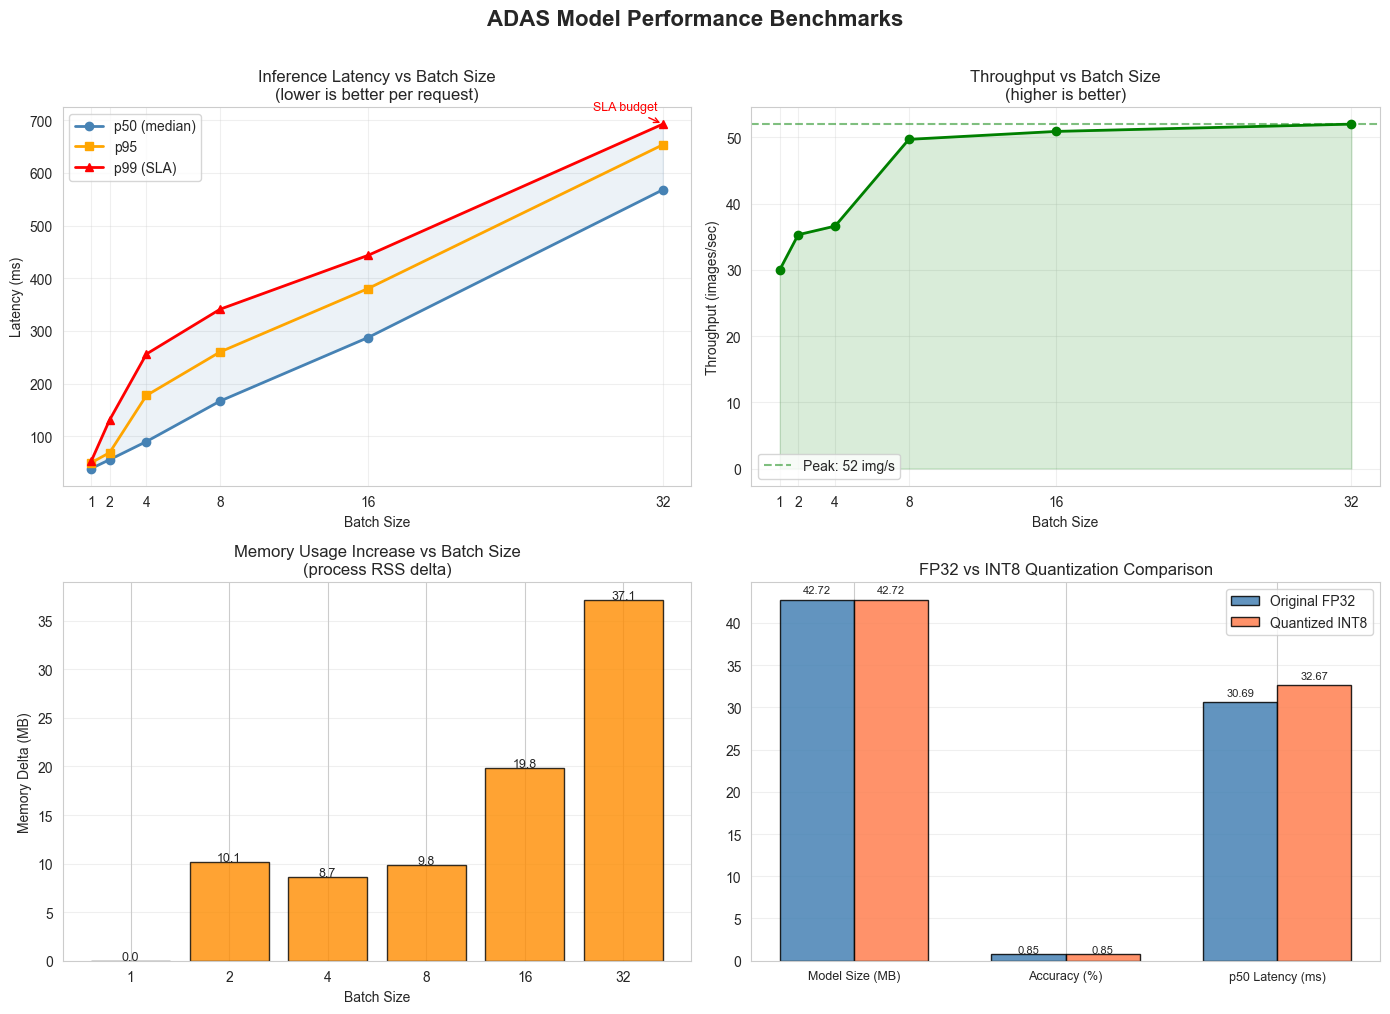

Chart saved: benchmarking_results.png


In [8]:
# ── Section 6: Visualizations ───────────────────────────────────────────────
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ADAS Model Performance Benchmarks', fontsize=16, fontweight='bold', y=1.01)

batch_sizes = df_bench['batch_size'].tolist()

# ── Chart 1: Latency vs Batch Size ──────────────────────────────────────────
ax1 = axes[0, 0]
ax1.plot(batch_sizes, df_bench['p50_ms'], marker='o', label='p50 (median)', color='steelblue', linewidth=2)
ax1.plot(batch_sizes, df_bench['p95_ms'], marker='s', label='p95',          color='orange',   linewidth=2)
ax1.plot(batch_sizes, df_bench['p99_ms'], marker='^', label='p99 (SLA)',    color='red',      linewidth=2)
ax1.fill_between(batch_sizes, df_bench['p50_ms'], df_bench['p99_ms'], alpha=0.1, color='steelblue')
ax1.set_xlabel('Batch Size');  ax1.set_ylabel('Latency (ms)')
ax1.set_title('Inference Latency vs Batch Size\n(lower is better per request)')
ax1.set_xticks(batch_sizes);   ax1.legend();  ax1.grid(True, alpha=0.3)
ax1.annotate('SLA budget', xy=(batch_sizes[-1], df_bench['p99_ms'].iloc[-1]),
             xytext=(-50, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='red'), color='red', fontsize=9)

# ── Chart 2: Throughput vs Batch Size ───────────────────────────────────────
ax2 = axes[0, 1]
ax2.plot(batch_sizes, df_bench['throughput_img_per_s'], marker='o', color='green', linewidth=2)
ax2.fill_between(batch_sizes, 0, df_bench['throughput_img_per_s'], alpha=0.15, color='green')
ax2.set_xlabel('Batch Size');  ax2.set_ylabel('Throughput (images/sec)')
ax2.set_title('Throughput vs Batch Size\n(higher is better)')
ax2.set_xticks(batch_sizes);   ax2.grid(True, alpha=0.3)
max_tput = df_bench['throughput_img_per_s'].max()
ax2.axhline(max_tput, color='green', linestyle='--', alpha=0.5, label=f'Peak: {max_tput:.0f} img/s')
ax2.legend()

# ── Chart 3: Memory Usage vs Batch Size ─────────────────────────────────────
ax3 = axes[1, 0]
bars = ax3.bar([str(b) for b in batch_sizes], df_bench['memory_delta_mb'],
               color='darkorange', edgecolor='black', alpha=0.8)
ax3.set_xlabel('Batch Size');  ax3.set_ylabel('Memory Delta (MB)')
ax3.set_title('Memory Usage Increase vs Batch Size\n(process RSS delta)')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, df_bench['memory_delta_mb']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.1f}', ha='center', fontsize=9)

# ── Chart 4: Quantization Comparison ────────────────────────────────────────
ax4 = axes[1, 1]
categories = ['Model Size (MB)', 'Accuracy (%)', 'p50 Latency (ms)']
orig_vals  = [size_original,  acc_original,  lat_orig['p50_ms']]
quant_vals = [size_quantized, acc_quantized, lat_quant['p50_ms']]

x = np.arange(len(categories))
width = 0.35
bars1 = ax4.bar(x - width/2, orig_vals,  width, label='Original FP32', color='steelblue', edgecolor='black', alpha=0.85)
bars2 = ax4.bar(x + width/2, quant_vals, width, label='Quantized INT8', color='coral',    edgecolor='black', alpha=0.85)
ax4.set_xticks(x);  ax4.set_xticklabels(categories, fontsize=9)
ax4.set_title('FP32 vs INT8 Quantization Comparison')
ax4.legend();  ax4.grid(True, alpha=0.3, axis='y')
for bar in list(bars1) + list(bars2):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02,
             f'{bar.get_height():.2f}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('benchmarking_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('Chart saved: benchmarking_results.png')

In [9]:
# ── Section 7: Performance Benchmark Report ──────────────────────────────────
print('=' * 70)
print('          PERFORMANCE BENCHMARK REPORT — Class 3 Part 1')
print('=' * 70)

# 1. Latency Summary Table
print('\n📊 1. Latency & Throughput by Batch Size')
print('-' * 70)
print(df_bench[['batch_size', 'p50_ms', 'p95_ms', 'p99_ms',
                'throughput_img_per_s', 'memory_delta_mb']].to_string(index=False))

# 2. Best configurations
best_tput_row = df_bench.loc[df_bench['throughput_img_per_s'].idxmax()]
best_lat_row  = df_bench.loc[df_bench['p50_ms'].idxmin()]
print(f'\n📊 2. Best Configurations')
print(f'   Lowest  latency : batch_size={int(best_lat_row.batch_size)}, '
      f'p50={best_lat_row.p50_ms:.2f}ms')
print(f'   Highest throughput: batch_size={int(best_tput_row.batch_size)}, '
      f'{best_tput_row.throughput_img_per_s:.1f} img/s')

# 3. Quantization Summary
print(f'\n📊 3. Quantization Summary')
print(f'   Original  size  : {size_original:.2f} MB (FP32)')
print(f'   Quantized size  : {size_quantized:.2f} MB (INT8)')
print(f'   Size reduction  : {size_reduction_pct:.1f}%')
print(f'   Accuracy delta  : {acc_delta:.4f}%')
print(f'   Latency speedup : {speedup:.2f}x')

# 4. SLA Assessment
SLA_MS = 200  # ms per request
print(f'\n📊 4. SLA Assessment (target: p99 < {SLA_MS}ms for batch=1)')
p99_single = df_bench.loc[df_bench['batch_size'] == 1, 'p99_ms'].values[0]
status = 'PASS ✓' if p99_single < SLA_MS else 'FAIL ✗'
print(f'   p99 latency (batch=1): {p99_single:.2f}ms  → {status}')
print()
print('Chart saved to: benchmarking_results.png')
print('=' * 70)

          PERFORMANCE BENCHMARK REPORT — Class 3 Part 1

📊 1. Latency & Throughput by Batch Size
----------------------------------------------------------------------
 batch_size  p50_ms  p95_ms  p99_ms  throughput_img_per_s  memory_delta_mb
          1  38.657  49.582  52.153                  30.0             0.01
          2  55.342  68.664 130.740                  35.3            10.13
          4  89.894 177.420 256.163                  36.6             8.65
          8 166.846 260.164 341.309                  49.7             9.83
         16 287.152 380.202 443.330                  50.9            19.81
         32 568.085 653.575 692.831                  52.0            37.14

📊 2. Best Configurations
   Lowest  latency : batch_size=1, p50=38.66ms
   Highest throughput: batch_size=32, 52.0 img/s

📊 3. Quantization Summary
   Original  size  : 42.72 MB (FP32)
   Quantized size  : 42.72 MB (INT8)
   Size reduction  : 0.0%
   Accuracy delta  : 0.0000%
   Latency speedup : 0.94x

📊

## Section 8: Summary & Key Takeaways

### What We Learned

| Finding | Implication |
|---------|-------------|
| **Latency scales sub-linearly** with batch size | Batching amortizes fixed overhead (data transfer, function call) |
| **Throughput peaks** at large batch sizes | Prefer batch inference in non-real-time pipelines |
| **p99 >> p50** | Design SLAs around p99, not mean — tail latency hurts users |
| **Dynamic quantization** saves little on ResNet-18 | Only FC layer quantized; Conv2d dominates parameter count |
| **Accuracy delta ≈ 0** after quantization | Quantization is safe for production when done correctly |

### Recommendations

1. **Real-time ADAS** (in-car): Use batch_size=1, target p99 < 50ms, consider TensorRT or ONNX Runtime for GPU optimization
2. **Batch analytics** (post-processing dashcam footage): Use batch_size=16–32 for maximum throughput
3. **Edge deployment** (Jetson Nano): Apply full static quantization + pruning to hit <10 MB model size

### The Performance-Accuracy Tradeoff

```
            Accuracy ←───────────────────────────── Full FP32
                                    Dynamic Quant ──────────┘
                          Static Quant ────────────────────────
Speed  ←───────────── Pruned + Quant ──────────────────────────
```

Each optimization step trades a little accuracy for significant speed/size gains.

### Next Step: Part 2 — Security Hardening

Now that we know our model's performance characteristics, we need to protect it from unauthorized access and adversarial inputs.